# Overview

This notebook provides a guide to reproduce our results used to compare the LSTM and multi-layer feed-forward neural network model architectures for predicting hourly temperature in Los Angeles using time series prediction.

Serving this aim, this workflow contains:
* Data loading from Global Integrated Surface Database 
* Data preprocessing
* Model training on various weather metrics
* Direct model architecture comparisons

# Getting Started

Prior to running this notebook and importing the following Python models, ensure that our custom Python environment has been created and is being used to run this notebook, as specified in our [README](README.md).

In [1]:
from pathlib import Path
from datetime import datetime, timedelta
import math
import random

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from ish_parser import ish_parser
from IPython.display import clear_output
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler

# Read Weather Data
The following cell defines the logic for parsing and aggregating the ISD (Global Integrated Surface Database ) files found in the `./data` directory. The data is parsed from the files on disk, grouped by hours, and "cleansed." This process is detailed in the report.

In [51]:
def read_ish_file (file_path):
    wf = ish_parser()

    with open(file_path) as fp:
        file_content = fp.read()
        wf.loads(file_content)

    all_station_observations = []
    for report in wf.get_observations():
        all_station_observations.append(report)

    return all_station_observations

def get_every_hour_of_year_iso(year):
    start_date = datetime(year, 1, 1)
    end_date = datetime(year, 12, 31, 23)

    current_date = start_date
    timestamps = []

    while current_date <= end_date:
        timestamps.append(current_date.isoformat())
        current_date += timedelta(hours=1)

    return timestamps

def save_divide(n, d):
    if d == 0:
        return None
    
    return n / d

def year_periodic_function(date_str):
    date_obj = datetime.strptime(date_str, "%Y-%m-%d")

    day_of_year = date_obj.timetuple().tm_yday

    phase_shift = math.pi / 2

    sin_value = math.sin((2 * math.pi * (day_of_year - 1) / 365) - phase_shift)
    sin_function = 1 - (sin_value + 1) / 2

    cos_value = math.cos((2 * math.pi * (day_of_year - 1) / 365) - phase_shift)
    cos_function = 1 - (cos_value + 1) / 2

    return sin_function, cos_function

def point_on_unit_circle(degrees):
    radians = math.radians(degrees)
    x = 0.5*math.cos(radians)+0.5
    y = 0.5*math.sin(radians)+0.5
    return (x, y)

class ManyObservationAggregator:
    def __init__(self, observations, year, name):
        self.observations = observations
        self.year = year
        self.name = name
        self.hours_of_year = get_every_hour_of_year_iso(self.year)
        self.grouped_observations = self.group_observations_by_hour()
        self.rows = self.get_all_rows()

    def get_metric(self, metric_key, rolling_on=False):
        res = []
        for i in range(len(self.rows)):
            val = self.rows[i][metric_key]
            prev = val

            if rolling_on and len(res):
                prev = res[i-1]

            rolling = 0.6*(val) + 0.4 * (prev)

            res.append(rolling)

        return res

    # we group all of the observations for each hour since there may be more than observation per hour
    def group_observations_by_hour(self):
        hour_mapping = dict()
        for hour in self.hours_of_year:
            hour_mapping[hour[0:13]] = []

        for observation in self.observations:
            hour = observation.datetime.isoformat()[0:13]
            if hour in hour_mapping:
                hour_mapping[hour].append(observation)

        return hour_mapping
    
    def get_all_rows(self):
        rows = []
        for i in range(len(self.hours_of_year)):
            rows.append(self.get_row(i, rows))

        return rows
    
    def get_row(self, i, rows):
        hour = self.hours_of_year[i]
        observations_in_hour = self.grouped_observations[hour[0:13]]
        agg_observations_in_hour = self.group_list_of_observations(observations_in_hour, hour)

        # fill in missing values as the previous values
        for key, value in agg_observations_in_hour.items():
            if value is None:
                if i != 0 :
                    agg_observations_in_hour[key] = rows[i - 1][key]
                else:
                    agg_observations_in_hour[key] = 0

        return agg_observations_in_hour


    # we aggergate the datapoints in each hour window
    def group_list_of_observations(self, observations_in_hour, date):
        total_temp = 0
        num_temp = 0

        total_wind_speed = 0
        num_wind_speed = 0

        total_sky_cover = 0
        num_sky_cover = 0

        total_wind_direction = 0
        num_wind_direction = 0

        total_dew_point = 0
        num_dew_point = 0

        total_pressure = 0
        num_pressure = 0

        total_vis = 0
        num_vis = 0

        total_precipitation = 0
        num_precipitation = 0

        station = ""

        hour_of_day = float(date[11:13])
        t_sin = 0.5*math.sin(math.pi * 2 * (1/24) * (hour_of_day+6)) + 0.5
        t_cos = 0.5*math.cos(math.pi * 2 * (1/24) * (hour_of_day+6)) + 0.5
        t_sin_year, t_cos_year = year_periodic_function(date[0:10])
        has = 0

        for observation in observations_in_hour:
            station = observation.weather_station
            if observation.air_temperature is not None and observation.air_temperature.get_fahrenheit() != "MISSING":
                total_temp += float(observation.air_temperature.get_fahrenheit())
                num_temp += 1

            if observation.wind_speed is not None and observation.wind_speed.get_MilesPerHour() is not None:
                total_wind_speed += float(observation.wind_speed.get_MilesPerHour())
                num_wind_speed += 1

            if observation.wind_speed is not None and observation.wind_speed.get_MilesPerHour() is not None:
                total_wind_speed += float(observation.wind_speed.get_MilesPerHour())
                num_wind_speed += 1

            if observation.sky_cover is not None and str(observation.sky_cover[0]["coverage"]) !=  "MISSING" and len(observation.sky_cover) > 0:
                total_sky_cover += float(str(observation.sky_cover[0]["coverage"]))
                num_sky_cover += 1

            if observation.visibility_distance is not None and str(observation.visibility_distance) !=  "MISSING":
                v = float(str(observation.visibility_distance.get_miles()))
                total_vis += float(v)
                num_vis += 1

            if observation.wind_direction is not None and str(observation.wind_direction) != "MISSING":
                total_wind_direction += float(str(observation.wind_direction))
                num_wind_direction += 1

            if observation.dew_point is not None and observation.dew_point.get_fahrenheit() != "MISSING":
                total_dew_point += float(observation.dew_point.get_fahrenheit())
                num_dew_point += 1

            if observation.sea_level_pressure is not None and str(observation.sea_level_pressure) != "MISSING":
                total_pressure += float(str(observation.sea_level_pressure))
                num_pressure += 1

            if observation.precipitation is not None and str(observation.precipitation) !=  "MISSING" and len(observation.precipitation) > 0:
                num = float(str(observation.precipitation[0]["depth"]))
                if num < 500:
                    total_precipitation += float(str(observation.precipitation[0]["depth"]))
                    num_precipitation += 1

        wind_direction_sin = None
        wind_direction_cos = None

        if num_wind_direction > 0:
            wind_direction_sin, wind_direction_cos = point_on_unit_circle(total_wind_direction / num_wind_direction)

        return {
            "station": station,
            "air_temp": save_divide(total_temp, num_temp),
            "wind_speed": save_divide(total_wind_speed, num_wind_speed),
            "sky_coverage": save_divide(total_sky_cover, num_sky_cover),
            "dew_point": save_divide(total_dew_point, num_dew_point),
            "pressure": save_divide(total_pressure, num_pressure),
            "vis": save_divide(total_vis, num_vis),
            "precip": save_divide(total_precipitation, num_precipitation),
            "wind_direction_sin": wind_direction_sin,
            "wind_direction_cos": wind_direction_cos,
            "t_sin": t_sin,
            "t_cos": t_cos,
            "t_sin_year": t_sin_year,
            "t_cos_year": t_cos_year,
        }


### Reading from Disk
This cell executes the above logic from the data files in the `./data` directory for each station and year. **Note: this process needs ~10gb of memory, and can take up to 2 minutes**.

In [4]:
years = ["2018","2019","2020", "2021", "2022", "2023"]
stations = {
    "lax": "722950-23174",
    "lan": "723820-23182",
    "san": "722900-23188",
    "cat": "722920-23191",
    "pam": "722868-93138"
}

all_weather = {}

data_path = Path().cwd() / Path("data")

for (place, station_id) in stations.items():
    all_weather[place] = {}

    for year in years:
        file_path = data_path / Path(f"{station_id}-{year}")
        observations = read_ish_file(f"{file_path}")
        all_weather[place][year] = ManyObservationAggregator(observations, int(year), place)

# Data Preprocessing

Here, training, validation, and test datasets are divided and stored by year. This infrastructure supports variable window lengths for both inputted time series (number of immediately previous hourly weather measurements considered before making temperature forecasts) and outputted time series (number of hours in future to predict temperature). Note that input and output window combinations summing to a multiple of 24 start all windows at midnight.

As discussed in greater detail in our report, note that normalization takes place on both the input and output variables.

In [5]:
def norm(x):
    """
    Input normalization strategy
    """
    mean = np.mean(x)
    std = np.std(x)
    return (x - mean)/std

def denorm(place, metric, years, normed):
    """
    Inverse the above norm function 
    """
    running = []

    for year in years:
        running = running + all_weather[place][year].get_metric(metric)

    mean = np.mean(running)
    std = np.std(running)

    return (normed*std) + mean

def get_group_metric(place, years, metric):
    """
    Collects all data for a metric for each year and location, and then normalizes it.
    """
    running = []

    for year in years:
        running = running + all_weather[place][year].get_metric(metric)

    return norm(running)


def window_array(array, window_length) -> list:
    """
    Split a 2D array into list of non-overlapping windows along the first (usu time) axis, 
    discarding remainder.
    """
    num_windows = len(array) // window_length
    windows = [array[i*window_length:(i+1)*window_length] for i in range(num_windows)]
    return windows

class ModelPreProcess:
    """
    Load and store training, validation, and testing data for custom dataset metrics.
    """
    def __init__(self, input_metrics, output_metrics, train_years, validation_years, test_years):
        self.train_years, self.validation_years = train_years, validation_years
        self.input_metrics, self.output_metrics = input_metrics, output_metrics
        self.test_years = test_years
        self.in_window_length = input_metrics[0][2] # assume same for all features
        self.out_window_length = output_metrics[0][2] # assume same for all features

        self.train_X = None
        self.train_Y = None
        self.full_train_Y = None
        self.validation_X = None
        self.validation_Y = None
        self.full_validation_Y = None
        self.test_X = None
        self.test_Y = None
        self.full_test_Y = None # vals corresponding to test_X and in test_Y future

    def get_year_data_with_window(self, years, metrics, n_inputs):
        res  = []
        for _, metric in enumerate(metrics):
            place = metric[0]
            key = metric[1]
            window_size = metric[2]
            data = get_group_metric(place, years, key)
            res.append((data, window_size))
        return res
    
    def get_training_data(self):
        self.train_X, self.train_Y, self.full_train_Y = self.transform_data(self.train_years)
    
    def get_validation_data(self):
        self.validation_X, self.validation_Y, self.full_validation_Y = self.transform_data(self.validation_years)

    def get_test_data(self):
        self.test_X, self.test_Y, self.full_test_Y = self.transform_data(self.test_years)
    
    def transform_data(self, years):
        data_by_metric = self.get_year_data_with_window(years, self.input_metrics+self.output_metrics, len(self.input_metrics))
        
        windows_by_metric = [window_array(metric[0], self.in_window_length+self.out_window_length) for metric in data_by_metric]

        windowed_metrics = np.transpose(np.array(windows_by_metric)).swapaxes(0,1)
        inputs_by_metric = windowed_metrics[:, :self.in_window_length, :len(self.input_metrics)]
        outputs_by_metric = windowed_metrics[:, self.in_window_length:, len(self.input_metrics):]
        full_outputs_by_metric = windowed_metrics[:, :, len(self.input_metrics):]

        return inputs_by_metric, outputs_by_metric, full_outputs_by_metric

# Model Training

In this section, we have a consistent interface for our LSTM, multi-layer feed-forward neural network, and hybrid architecture approaches, supporting real-time loss and metric graphs while training, model evaluation, integrated hyperparameter tuning, and output plotting. 

Interactive loss and metric graphs while training were implemented in the `PlotLearning` class (credit [Daniel Carlander](https://gist.github.com/danicrg/ab3bc7c330ce152bcf643231de4820e9)).

In [47]:

class PlotLearning(tf.keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        if len(metrics) == 1:
            axs.plot(range(1, epoch + 2), 
                        self.metrics[metrics[0]], 
                        label='Training ' + metrics[0])
            axs.set_xlabel("Epoch")
            axs.set_ylabel("Error")
            axs.plot(range(1, epoch + 2), 
                        self.metrics['val_' + metrics[0]], 
                        label='Validation ' + metrics[0])
            axs.legend()
            axs.grid()

        else:
            for i, metric in enumerate(metrics):
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics[metric], 
                            label='Training ' + metric)
                axs[i].set_xlabel("Epoch")
                axs[i].set_ylabel("Error")
                if logs['val_' + metric]:
                    axs[i].plot(range(1, epoch + 2), 
                                self.metrics['val_' + metric], 
                                label='Validation ' + metric)
                    axs[i].set_xlabel("Epoch")
                    axs[i].set_ylabel("Error")
                    
                axs[i].legend()
                axs[i].grid()

        plt.tight_layout()
        plt.show()
        
class LSTMWeatherPredictor:
    """
    Weather prediction model using LSTM architecture.
    """
    def __init__(self, in_window_len, out_window_len, n_features_in, n_features_out, epochs, batch_size):
        self.epochs = epochs
        self.in_window_len = in_window_len
        self.out_window_len = out_window_len
        self.n_features_in = n_features_in
        self.n_features_out = n_features_out
        self.batch_size = batch_size

        self.model = tf.keras.Sequential([
            tf.keras.layers.LSTM(444, input_shape=(self.in_window_len, self.n_features_in), 
                                 return_sequences=True, kernel_regularizer=tf.keras.regularizers.L2(l2=0.04)),
            tf.keras.layers.LSTM(256, kernel_regularizer=tf.keras.regularizers.L2(l2=0.04), return_sequences=True),
            tf.keras.layers.LSTM(96, kernel_regularizer=tf.keras.regularizers.L2(l2=0.04)),
            tf.keras.layers.Dense(self.out_window_len*self.n_features_out)
        ])
        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0003)
        self.model.compile(optimizer=optimizer, loss='mse')

    def train(self, train_X, train_Y, validation_X, validation_Y):
        training_X, training_Y = shuffle(np.array(train_X), np.array(train_Y))
        validating_X, validating_Y = shuffle(np.array(validation_X), np.array(validation_Y))
        callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
        self.model.fit(np.array(training_X), np.array(training_Y), validation_data=(validating_X, validating_Y), 
                       epochs=self.epochs, batch_size=self.batch_size, callbacks=[callback, PlotLearning()])
        
    def evaluate(self, X_test, Y_test, place, year, metric):
        Y_true = Y_test
        Y_pred = self.model.predict(X_test)

        mae = np.mean(abs(np.squeeze(denorm(place, metric, year, Y_true)) - np.squeeze(denorm(place, metric, year, Y_pred))))
        mse = np.mean(np.square(np.squeeze(denorm(place, metric, year, Y_true)) - np.squeeze(denorm(place, metric, year, Y_pred))))

        print(f"MAE of test data: {round(mae, 6)}")
        print(f"MSE of test data: {round(mse, 6)}")

    def get_predictions_at_time(self, ind, X_test, Y_test, Y_full_true, place, year, metric):
        Y_true = Y_full_true
        Y_pred = self.model.predict(X_test)

        prediction = Y_pred[ind]
        truth = Y_true[ind]
        real_x = np.arange(0, len(truth))
        predicted_x = len(truth) - len(prediction) + np.arange(0, len(prediction))

        truth = denorm(place, metric, year, truth)
        prediction = denorm(place, metric, year, prediction)

        return {
            "predicted_x": predicted_x,
            "prediction": prediction,
            "real_x": real_x,
            "truth": truth,
        }

    def plot_predictions_at_random_point(self, X_test, Y_test, Y_full_true):
        Y_true = Y_full_true
        Y_pred = self.model.predict(X_test)

        rand_inds = random.sample(range(Y_pred.shape[0]), 3)

        for ind in rand_inds:
            prediction = Y_pred[ind]
            truth = Y_true[ind]
            real_x = np.arange(0, len(truth))
            predicted_x = len(truth) - len(prediction) + np.arange(0, len(prediction)) 

            plt.rcParams['figure.figsize'] = [16, 3]
            plt.rcParams['figure.dpi'] = 100
            plt.plot(predicted_x, prediction, label="Prediction", color="green")
            plt.plot(real_x, truth, label="Truth")

            plt.axvline(len(truth)-len(prediction), color="red")
            plt.xlabel("Time (hours)")
            plt.legend()
            plt.figure()

class HybridWeatherPredictor:
    """
    Weather prediction model using both LSTM and multi-layer feed-forward neural network.
    """
    def __init__(self, in_window_len, out_window_len, n_features_in, n_features_out, epochs, batch_size):
        self.epochs = epochs
        self.in_window_len = in_window_len
        self.out_window_len = out_window_len
        self.n_features_in = n_features_in
        self.n_features_out = n_features_out
        self.batch_size = batch_size

        self.model = tf.keras.Sequential([
            tf.keras.layers.LSTM(444, input_shape=(self.in_window_len, self.n_features_in), 
                                 return_sequences=True, kernel_regularizer=tf.keras.regularizers.L2(l2=0.02)),
            tf.keras.layers.LSTM(256, kernel_regularizer=tf.keras.regularizers.L2(l2=0.02)),
            tf.keras.layers.Dense(216, kernel_regularizer=tf.keras.regularizers.L2(l2=0.01), activation='relu'),
            tf.keras.layers.Dense(128, kernel_regularizer=tf.keras.regularizers.L2(l2=0.01), activation='relu'),
            tf.keras.layers.Dense(self.out_window_len*self.n_features_out)
        ])
        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.000025)
        self.model.compile(optimizer=optimizer, loss='mse')

    def train(self, train_X, train_Y, validation_X, validation_Y):
        callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=8)
        self.model.fit(np.array(train_X), np.array(train_Y), validation_data=(validation_X, validation_Y), 
                       epochs=self.epochs, batch_size=self.batch_size, callbacks=[callback, PlotLearning()])
        
    def evaluate(self, X_test, Y_test, place, year, metric):
        Y_true = Y_test
        Y_pred = self.model.predict(X_test)

        mae = np.mean(abs(np.squeeze(denorm(place, metric, year, Y_true)) - np.squeeze(denorm(place, metric, year, Y_pred))))
        mse = np.mean(np.square(np.squeeze(denorm(place, metric, year, Y_true)) - np.squeeze(denorm(place, metric, year, Y_pred))))
        print(f"MAE of test data: {round(mae, 6)}")
        print(f"MSE of test data: {round(mse, 6)}")

    def get_predictions_at_time(self, ind, X_test, Y_test, Y_full_true, place, year, metric):
        Y_true = Y_full_true
        Y_pred = self.model.predict(X_test)

        prediction = Y_pred[ind]
        truth = Y_true[ind]
        real_x = np.arange(0, len(truth))
        predicted_x = len(truth) - len(prediction) + np.arange(0, len(prediction))

        truth = denorm(place, metric, year, truth)
        prediction = denorm(place, metric, year, prediction)

        return {
            "predicted_x": predicted_x,
            "prediction": prediction,
            "real_x": real_x,
            "truth": truth,
        }

    def plot_predictions_at_random_point(self, X_test, Y_test, Y_full_true):
        Y_true = Y_full_true
        Y_pred = self.model.predict(X_test)

        rand_inds = random.sample(range(Y_pred.shape[0]), 3)

        for ind in rand_inds:
            prediction = Y_pred[ind]
            truth = Y_true[ind]
            real_x = np.arange(0, len(truth))
            predicted_x = len(truth) - len(prediction) + np.arange(0, len(prediction)) 

            plt.rcParams['figure.figsize'] = [16, 3]
            plt.rcParams['figure.dpi'] = 100
            plt.plot(predicted_x, prediction, label="Prediction", color="green")
            plt.plot(real_x, truth, label="Truth")

            plt.axvline(len(truth)-len(prediction), color="red")
            plt.xlabel("Time (hours)")
            plt.legend()
            plt.figure()

class LinearWeatherPredictor:
    """
    Weather prediction model using multi-layer feed-forward neural network.
    """
    def __init__(self, in_window_len, out_window_len, n_features_in, n_features_out, epochs, batch_size):
        self.epochs = epochs
        self.in_window_len = in_window_len
        self.out_window_len = out_window_len
        self.n_features_in = n_features_in
        self.n_features_out = n_features_out
        self.batch_size = batch_size

        self.model = tf.keras.Sequential([
            tf.keras.layers.Dense(self.n_features_in*self.in_window_len, kernel_regularizer=tf.keras.regularizers.L2(l2=0.02), activation='relu'),
            tf.keras.layers.Dense(944, kernel_regularizer=tf.keras.regularizers.L2(l2=0.02), activation='relu'),
            tf.keras.layers.Dense(512, kernel_regularizer=tf.keras.regularizers.L2(l2=0.015), activation='relu'),
            tf.keras.layers.Dense(216, kernel_regularizer=tf.keras.regularizers.L2(l2=0.01), activation='relu'),
            tf.keras.layers.Dense(128, kernel_regularizer=tf.keras.regularizers.L2(l2=0.01), activation='relu'),
            tf.keras.layers.Dense(self.out_window_len*self.n_features_out)
        ])
        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.000025)
        self.model.compile(optimizer=optimizer, loss='mse')

    def train(self, train_X, train_Y, validation_X, validation_Y):
        callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20)

        self.model.fit(np.array(train_X), np.array(train_Y), validation_data=(validation_X, validation_Y), 
                       epochs=self.epochs, batch_size=self.batch_size, callbacks=[callback, PlotLearning()])
        
    def evaluate(self, X_test, Y_test, place, year, metric):
        Y_true = Y_test
        Y_pred = self.model.predict(X_test)

        mae = np.mean(abs(np.squeeze(denorm(place, metric, year, Y_true)) - np.squeeze(denorm(place, metric, year, Y_pred))))
        mse = np.mean(np.square(np.squeeze(denorm(place, metric, year, Y_true)) - np.squeeze(denorm(place, metric, year, Y_pred))))

        print(f"MAE of test data: {round(mae, 6)}")
        print(f"MSE of test data: {round(mse, 6)}")

    def get_predictions_at_time(self, ind, X_test, Y_test, Y_full_true, place, year, metric):
        Y_true = Y_full_true
        Y_pred = self.model.predict(X_test.reshape((X_test.shape[0], -1)))

        prediction = Y_pred[ind]
        truth = Y_true[ind]
        real_x = np.arange(0, len(truth))
        predicted_x = len(truth) - len(prediction) + np.arange(0, len(prediction))

        truth = denorm(place, metric, year, truth)
        prediction = denorm(place, metric, year, prediction)

        return {
            "predicted_x": predicted_x,
            "prediction": prediction,
            "real_x": real_x,
            "truth": truth,
        }

    def plot_predictions_at_random_point(self, X_test, Y_test, Y_full_true):
        Y_true = Y_full_true
        Y_pred = self.model.predict(X_test.reshape((X_test.shape[0], -1)))

        rand_inds = random.sample(range(Y_pred.shape[0]), 3)

        for ind in rand_inds:
            prediction = Y_pred[ind]
            truth = Y_true[ind]
            real_x = np.arange(0, len(truth))
            predicted_x = len(truth) - len(prediction) + np.arange(0, len(prediction)) 

            plt.rcParams['figure.figsize'] = [16, 3]
            plt.rcParams['figure.dpi'] = 100
            plt.plot(real_x, truth, label="Truth")
            plt.plot(predicted_x, prediction, label="Prediction", color="green")

            plt.axvline(len(truth)-len(prediction), color="red")
            plt.xlabel("Time (hours)")
            plt.legend()
            plt.figure()

## Level Helpers and Definitions
The following cell defines a "level." This class acts as a helper class to train and examine the models on a fixed set of data (metrics to consume, and metrics to predict). This allows us to easily compare the LSTM model, Hybrid Model, and Linear Model. These comparisons are discussed in detail in the report.

In [80]:
class Level:
    def __init__(self, input, output, epochs=50):
        self.train_years = ["2018", "2019", "2020", "2021"]
        self.validation_years = ["2022"]
        self.test_years = ["2023"]

        self.DataClass = ModelPreProcess(input, output, self.train_years, self.validation_years, self.test_years)
        self.DataClass.get_training_data()
        self.DataClass.get_validation_data()
        self.DataClass.get_test_data()

        self.in_window_len = self.DataClass.train_X.shape[1]
        self.out_window_len = self.DataClass.train_Y.shape[1]
        self.n_features_in = self.DataClass.train_X.shape[2]
        self.n_features_out = self.DataClass.train_Y.shape[2]
        self.epochs = epochs
        self.batch_size = 32

        self.lstm_model = LSTMWeatherPredictor(self.in_window_len, self.out_window_len, self.n_features_in, self.n_features_out, self.epochs, batch_size=64)
        self.hybrid_model = HybridWeatherPredictor(self.in_window_len, self.out_window_len, self.n_features_in, self.n_features_out, self.epochs, self.batch_size)
        self.linear_model= LinearWeatherPredictor(self.in_window_len, self.out_window_len, self.n_features_in, self.n_features_out, self.epochs, self.batch_size)

    def train_lstm(self):
        self.lstm_model.train(self.DataClass.train_X, self.DataClass.train_Y, self.DataClass.validation_X, self.DataClass.validation_Y)
        self.lstm_model.evaluate(self.DataClass.test_X, self.DataClass.test_Y, 
                                 "lax", self.test_years, "air_temp")

    def train_hybrid(self):
        self.hybrid_model.train(self.DataClass.train_X, self.DataClass.train_Y, self.DataClass.validation_X, self.DataClass.validation_Y)
        self.hybrid_model.evaluate(self.DataClass.test_X, self.DataClass.test_Y,
                                   "lax", self.test_years, "air_temp")

    def train_linear(self):
        self.linear_model.train(
            self.DataClass.train_X.reshape((self.DataClass.train_X.shape[0], -1)),
            self.DataClass.train_Y.reshape((self.DataClass.train_Y.shape[0], -1)),
            self.DataClass.validation_X.reshape((self.DataClass.validation_X.shape[0], -1)),
            self.DataClass.validation_Y.reshape((self.DataClass.validation_Y.shape[0], -1))
        )
        self.linear_model.evaluate(
            self.DataClass.test_X.reshape((self.DataClass.test_X.shape[0], -1)), self.DataClass.test_Y.reshape((self.DataClass.test_Y.shape[0], -1)),
            "lax", self.test_years, "air_temp")

    def plot_predictions(self, y_label):
        rand_inds = random.sample(range(self.DataClass.full_test_Y.shape[0]), 3)

        i = 0
        for ind in rand_inds:
            i += 1
            lstm_p = self.lstm_model.get_predictions_at_time(ind, self.DataClass.test_X, self.DataClass.test_Y, self.DataClass.full_test_Y, "lax", self.test_years, "air_temp")
            hybrid_p = self.hybrid_model.get_predictions_at_time(ind, self.DataClass.test_X, self.DataClass.test_Y, self.DataClass.full_test_Y, "lax", self.test_years, "air_temp")
            linear_p = self.linear_model.get_predictions_at_time(ind, self.DataClass.test_X, self.DataClass.test_Y, self.DataClass.full_test_Y, "lax", self.test_years, "air_temp")

            plt.rcParams['figure.figsize'] = [16, 3]
            plt.rcParams['figure.dpi'] = 100
            plt.plot(lstm_p["real_x"], lstm_p["truth"], label="Truth")

            plt.plot(lstm_p["predicted_x"], lstm_p["prediction"], label="LSTM Prediction", color="green")
            plt.plot(hybrid_p["predicted_x"], hybrid_p["prediction"], label="Hybrid Prediction", color="purple")
            plt.plot(linear_p["predicted_x"], linear_p["prediction"], label="Linear Prediction", color="cyan")

            plt.axvline(len(lstm_p["truth"])-len(lstm_p["prediction"]), color="red")
            plt.ylabel(y_label)
            plt.xlabel("Time (hours)")
            plt.title(f"Example #{i}")
            plt.legend()
            plt.figure()

        clear_output()

    
level_1 = Level(
    [
        ("lax", "air_temp", 24),
        ("lax", "wind_speed", 24),
        ("lax", "sky_coverage", 24),
        ("lax", "dew_point", 24),
        ("lax", "pressure", 24),
        ("lax", "vis", 24),
        ("lax", "wind_direction_sin", 24),
        ("lax", "wind_direction_cos", 24),
        ("lax", "precip", 24),
        ("lax", "t_sin_year", 24),
        ("lax", "t_cos_year", 24)
    ],
    [
        ("lax", "air_temp", 24)
    ],
    epochs=300
)

level_2 = Level(
    [
        ("lax", "air_temp", 24),
        ("lax", "wind_speed", 24),
        ("lax", "sky_coverage", 24),
        ("lax", "dew_point", 24),
        ("lax", "pressure", 24),
        ("lax", "vis", 24),
        ("lax", "wind_direction_sin", 24),
        ("lax", "wind_direction_cos", 24),
        ("lax", "precip", 24),

        ("lax", "t_sin_year", 24),
        ("lax", "t_cos_year", 24),

        ("san", "air_temp", 24),
        ("san", "wind_speed", 24),
        ("san", "sky_coverage", 24),
        ("san", "dew_point", 24),
        ("san", "pressure", 24),
        ("san", "vis", 24),
        ("san", "wind_direction_sin", 24),
        ("san", "wind_direction_cos", 24),
        ("san", "precip", 24),

        ("lan", "air_temp", 24),
        ("lan", "wind_speed", 24),
        ("lan", "sky_coverage", 24),
        ("lan", "dew_point", 24),
        ("lan", "pressure", 24),
        ("lan", "vis", 24),
        ("lan", "wind_direction_sin", 24),
        ("lan", "wind_direction_cos", 24),
        ("lan", "precip", 24),

        ("cat", "air_temp", 24),
        ("cat", "wind_speed", 24),
        ("cat", "sky_coverage", 24),
        ("cat", "dew_point", 24),
        ("cat", "pressure", 24),
        ("cat", "vis", 24),
        ("cat", "wind_direction_sin", 24),
        ("cat", "wind_direction_cos", 24),
        ("cat", "precip", 24),

        ("pam", "air_temp", 24),
        ("pam", "wind_speed", 24),
        ("pam", "sky_coverage", 24),
        ("pam", "dew_point", 24),
        ("pam", "pressure", 24),
        ("pam", "vis", 24),
        ("pam", "wind_direction_sin", 24),
        ("pam", "wind_direction_cos", 24),
        ("pam", "precip", 24),
    ],
    [
        ("lax", "air_temp", 24)
    ],
    epochs=300
)

level_3 = Level(
    [
        ("lax", "air_temp", 72),
        ("lax", "wind_speed", 72),
        ("lax", "sky_coverage", 72),
        ("lax", "dew_point", 72),
        ("lax", "pressure", 72),
        ("lax", "vis", 72),
        ("lax", "wind_direction_sin", 72),
        ("lax", "wind_direction_cos", 72),
        ("lax", "precip", 72),

        ("lax", "t_sin_year", 72),
        ("lax", "t_cos_year", 72),

        ("san", "air_temp", 72),
        ("san", "wind_speed", 72),
        ("san", "sky_coverage", 72),
        ("san", "dew_point", 72),
        ("san", "pressure", 72),
        ("san", "vis", 72),
        ("san", "wind_direction_sin", 72),
        ("san", "wind_direction_cos", 72),
        ("san", "precip", 72),

        ("lan", "air_temp", 72),
        ("lan", "wind_speed", 72),
        ("lan", "sky_coverage", 72),
        ("lan", "dew_point", 72),
        ("lan", "pressure", 72),
        ("lan", "vis", 72),
        ("lan", "wind_direction_sin", 72),
        ("lan", "wind_direction_cos", 72),
        ("lan", "precip", 72),

        ("cat", "air_temp", 72),
        ("cat", "wind_speed", 72),
        ("cat", "sky_coverage", 72),
        ("cat", "dew_point", 72),
        ("cat", "pressure", 72),
        ("cat", "vis", 72),
        ("cat", "wind_direction_sin", 72),
        ("cat", "wind_direction_cos", 72),
        ("cat", "precip", 72),

        ("pam", "air_temp", 72),
        ("pam", "wind_speed", 72),
        ("pam", "sky_coverage", 72),
        ("pam", "dew_point", 72),
        ("pam", "pressure", 72),
        ("pam", "vis", 72),
        ("pam", "wind_direction_sin", 72),
        ("pam", "wind_direction_cos", 72),
        ("pam", "precip", 72),
    ],
    [
        ("lax", "air_temp", 24)
    ],
    epochs=400
)



## Level 1
This level is trained on all weather metrics from LAX (Los Angeles), with 24 hours of history.

### LSTM Loss & Error

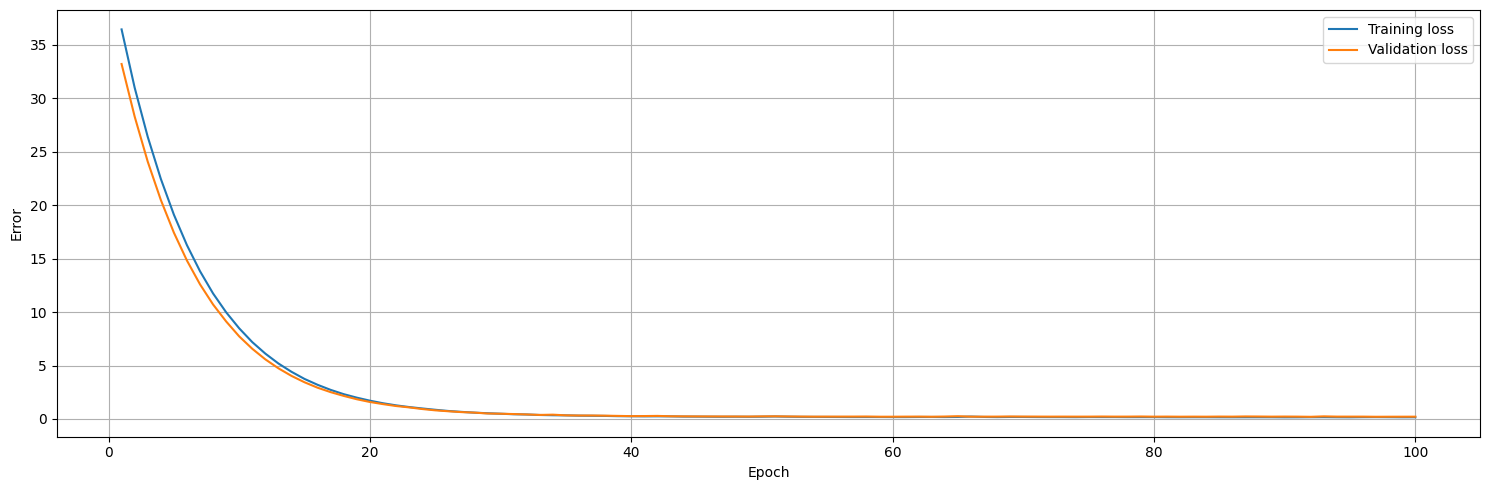

6/6 [==============================] - 1s 32ms/step
MAE of test data: 2.048329
MSE of test data: 7.987299


In [49]:
level_1.train_lstm()

### Hybrid Loss & Error

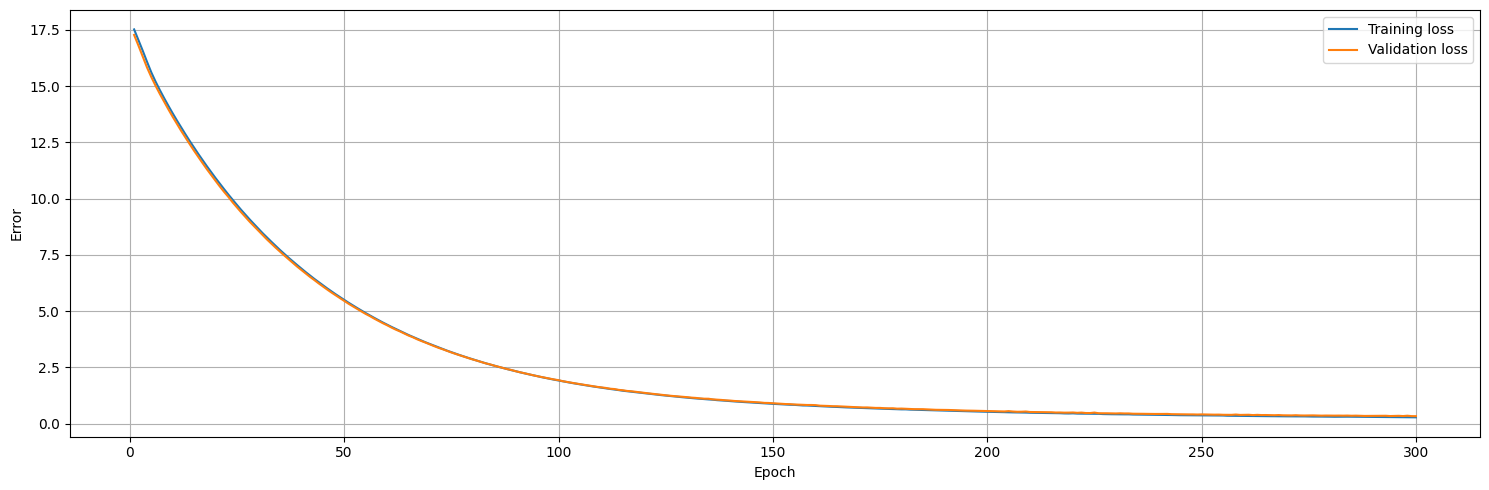

6/6 [==============================] - 1s 25ms/step
MAE of test data: 2.136263
MSE of test data: 8.274816


In [50]:
level_1.train_hybrid()

### Linear Loss & Error

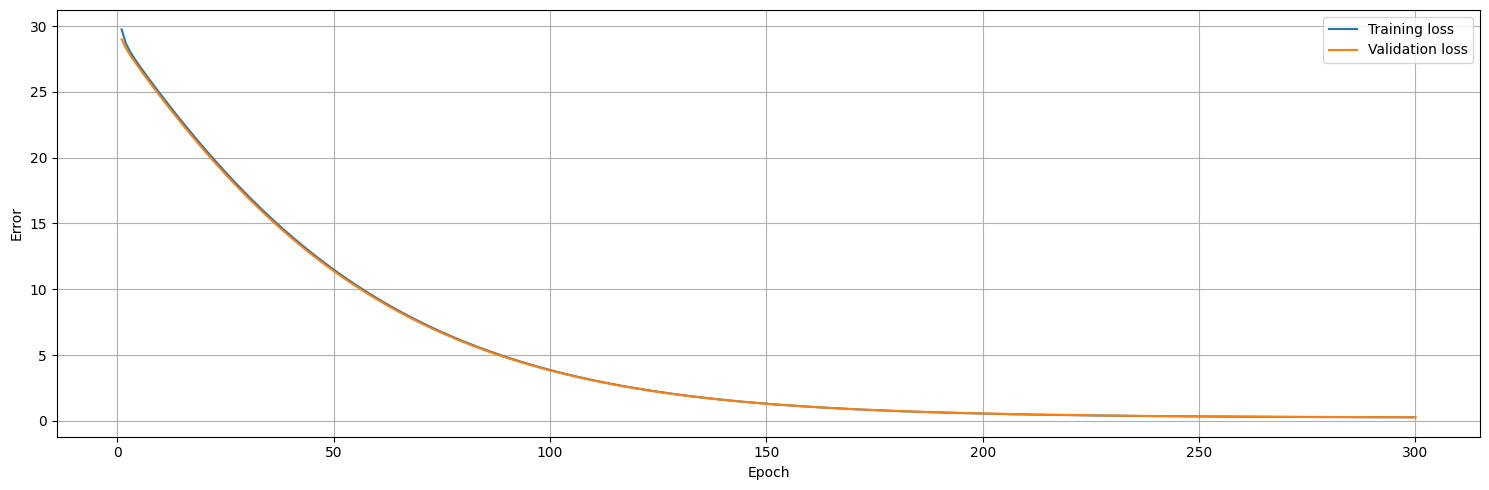

6/6 [==============================] - 0s 4ms/step
MAE of test data: 1.874671
MSE of test data: 6.578485


In [52]:
level_1.train_linear()

### Example Charts

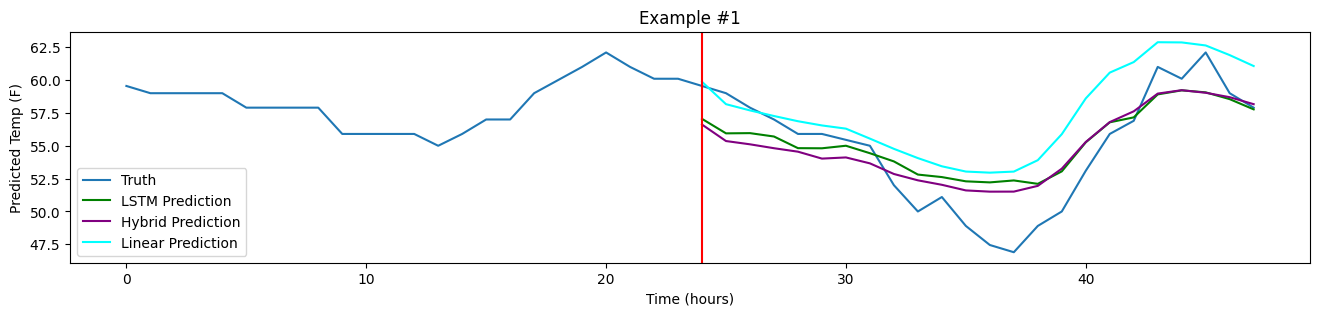

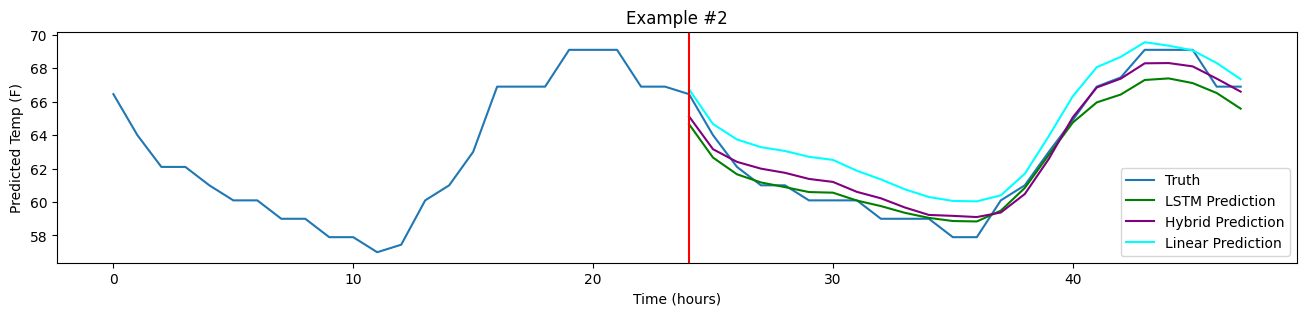

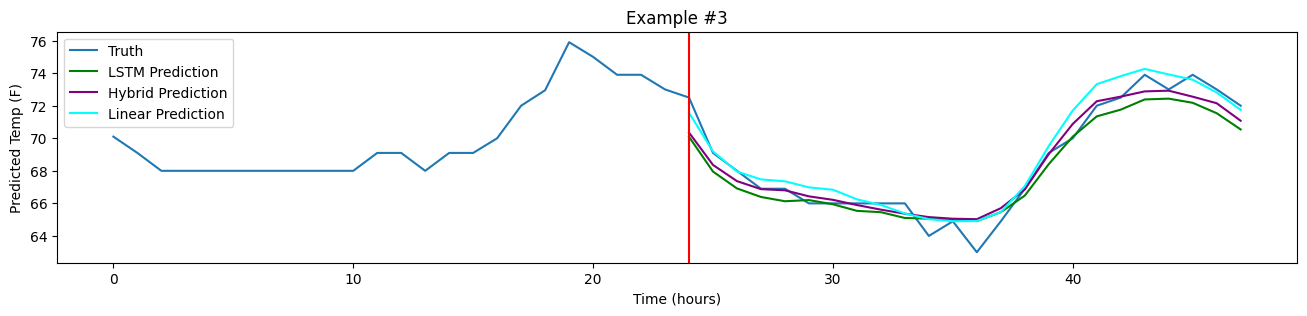

<Figure size 1600x300 with 0 Axes>

In [78]:
level_1.plot_predictions("Predicted Temp (F)")

## Level 2
This level is trained on all weather metrics from all 5 weather stations, with 24 hours of history.

### LSTM Loss & Error

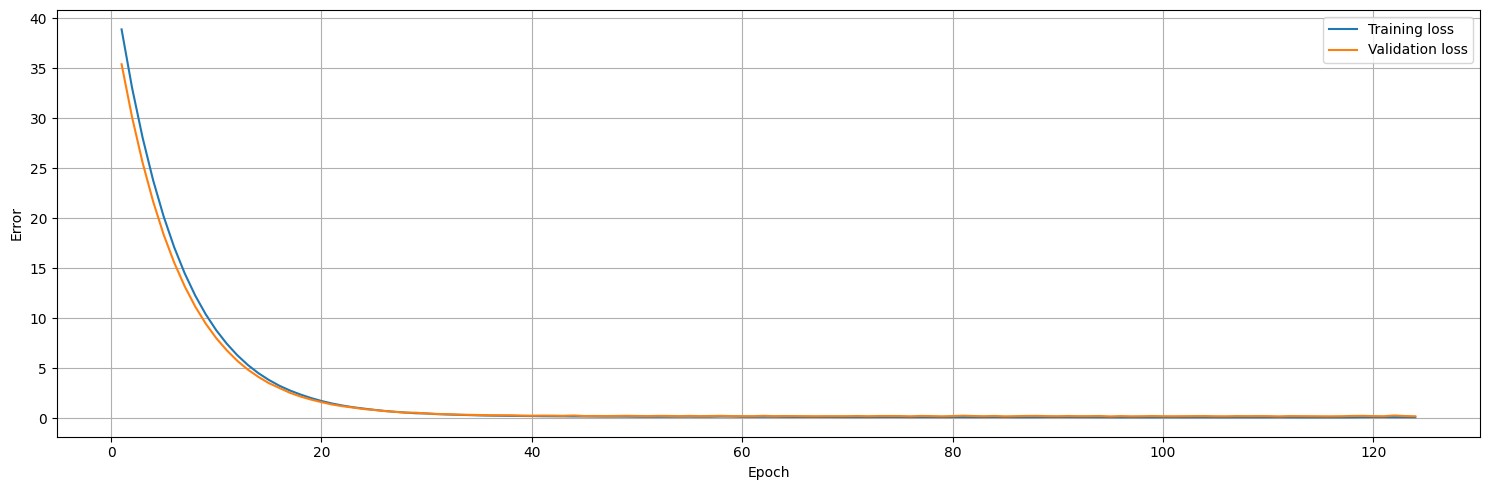

6/6 [==============================] - 1s 38ms/step
MAE of test data: 2.175356
MSE of test data: 8.887671


In [82]:
level_2.train_lstm()

### Hybrid Loss & Error

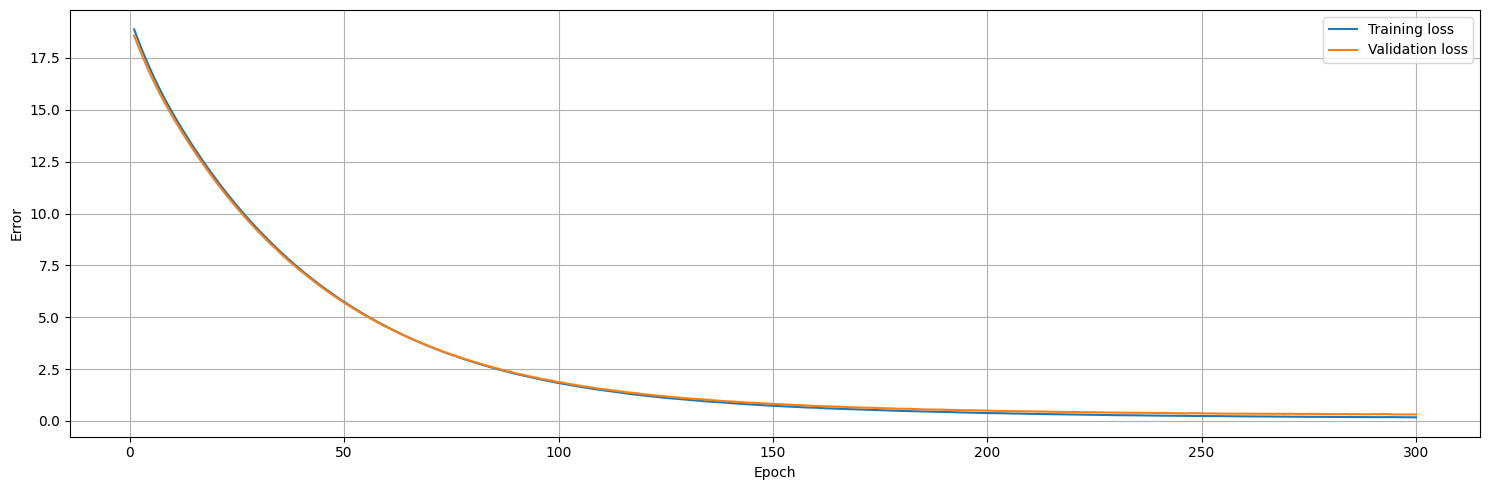

6/6 [==============================] - 1s 31ms/step
MAE of test data: 2.172691
MSE of test data: 8.869209


In [83]:
level_2.train_hybrid()

### Linear Loss & Error

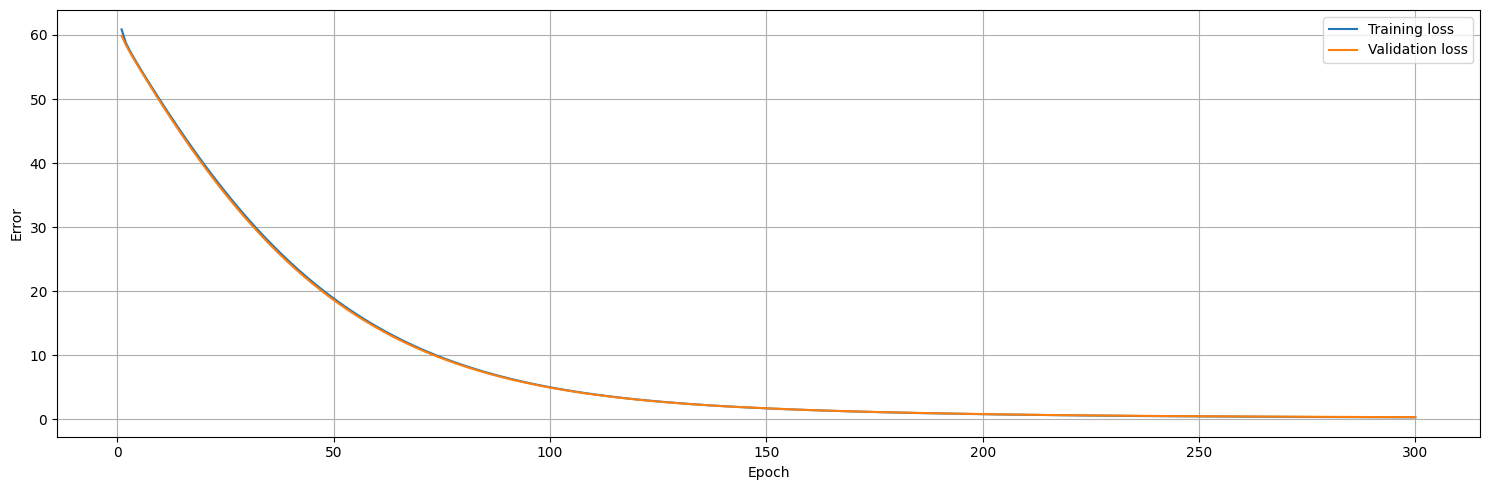

6/6 [==============================] - 0s 4ms/step
MAE of test data: 1.853091
MSE of test data: 6.277174


In [81]:
level_2.train_linear()

### Example Charts

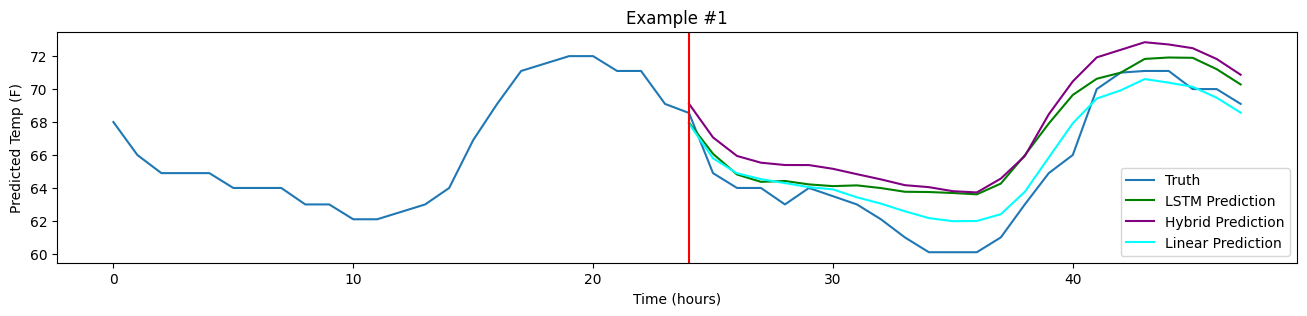

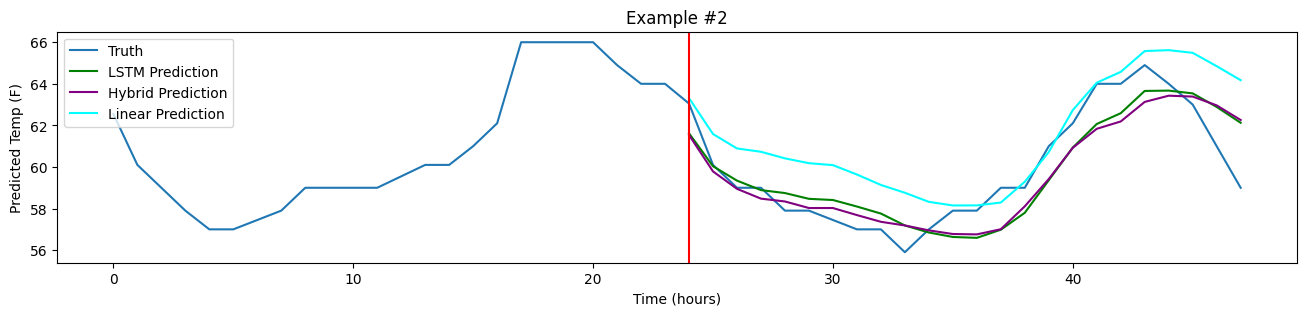

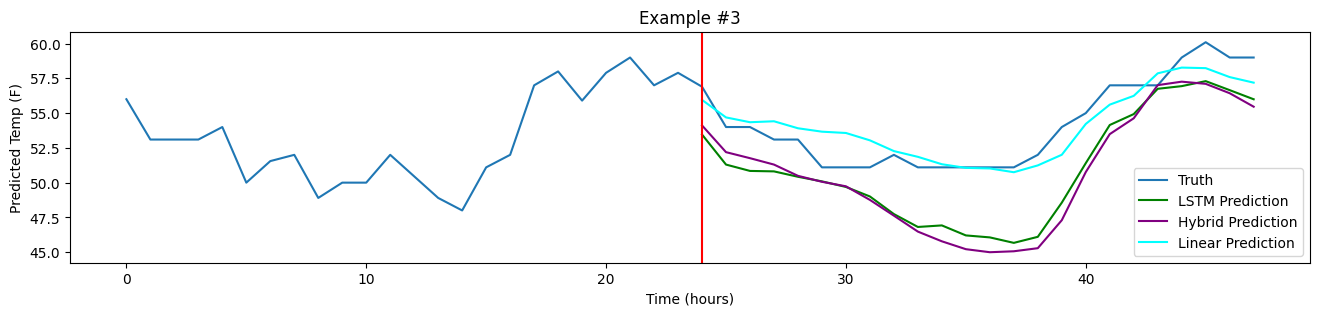

<Figure size 1600x300 with 0 Axes>

In [116]:
level_2.plot_predictions("Predicted Temp (F)")

## Level 3
This level is trained on all weather metrics from all 5 weather stations, with 72 hours of history.

### LSTM Loss & Error

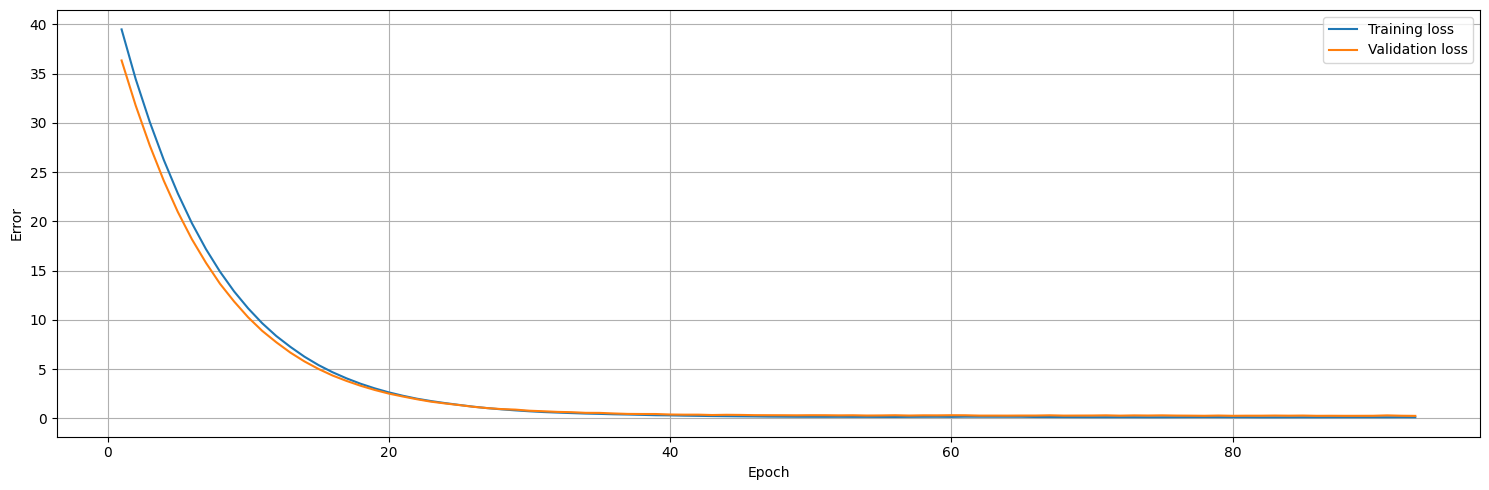

3/3 [==============================] - 1s 46ms/step
MAE of test data: 2.524404
MSE of test data: 11.92902


In [33]:
level_3.train_lstm()

### Hybrid Loss & Error

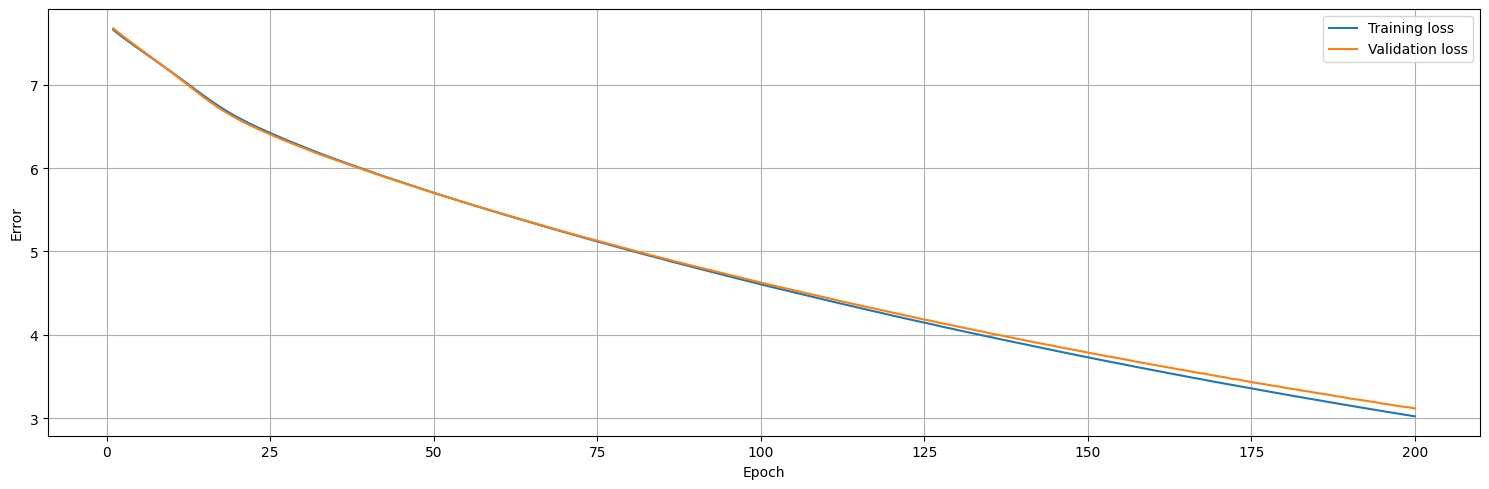

3/3 [==============================] - 1s 45ms/step
MAE of test data: 2.316882
MSE of test data: 9.618234


In [34]:
level_3.train_hybrid()

### Linear Loss & Error

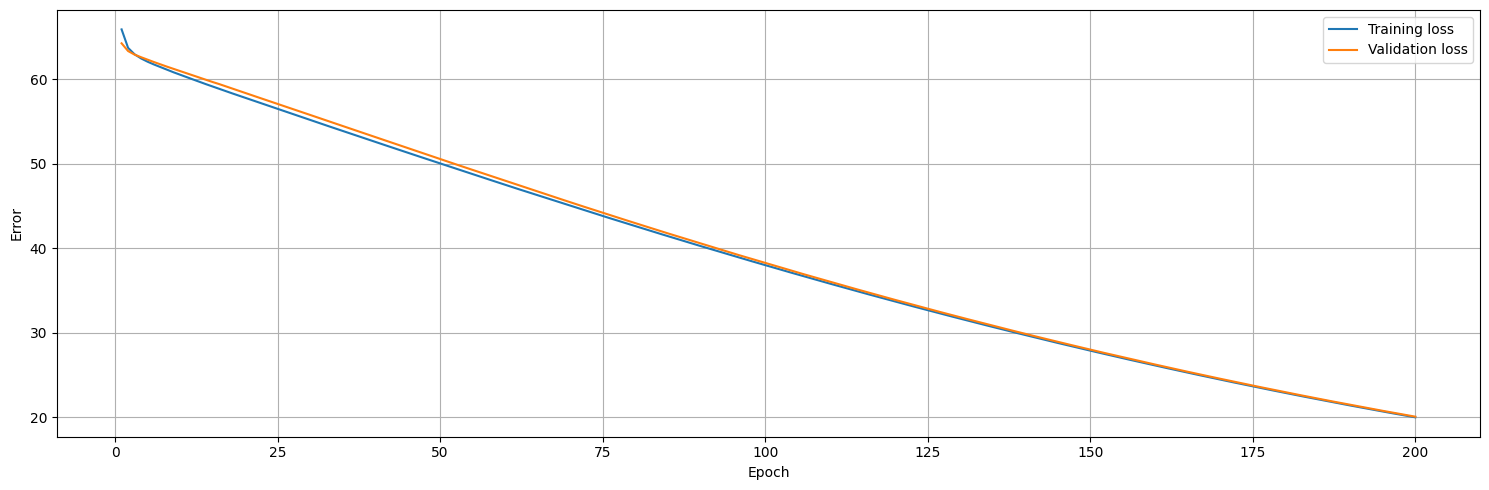

3/3 [==============================] - 0s 6ms/step
MAE of test data: 2.371384
MSE of test data: 9.819698


In [35]:
level_3.train_linear()

### Example Charts

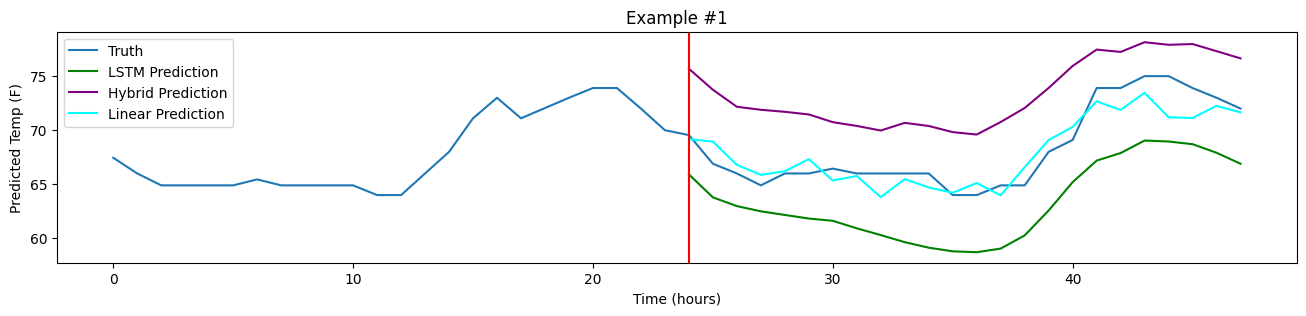

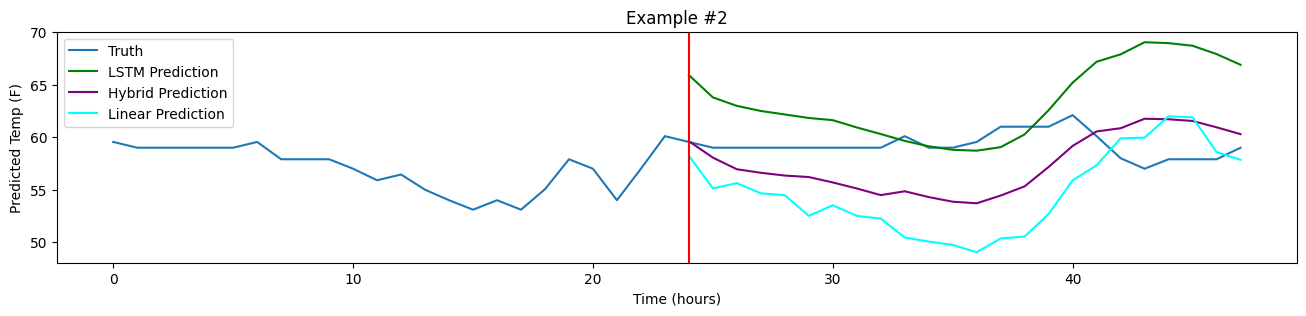

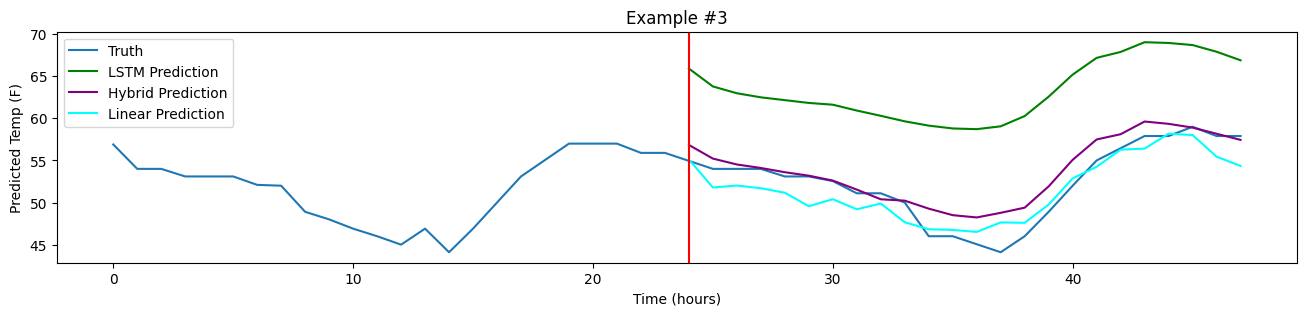

<Figure size 1600x300 with 0 Axes>

In [ ]:
level_3.plot_predictions("Predicted Temp (F)")